In [142]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

print('test')

In [148]:
#Look at an ensemble member to see what it looks like
ds1 = xr.open_dataset('LENS2/ENSO_SST/ENSO_Project_SST_r10i1181p1f1.nc')
#ds1 = ds1.sel(lat=slice(-15,15),lon=slice(120,180+(180-80)))
sst1 = ds1.SST
n_lats,n_lons = sst1.shape[1],sst1.shape[2] #64,96
sst1


<xarray.DataArray 'SST' (time: 1980, lat: 64, lon: 96)>
[12165120 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 -89.06 -86.23 -83.4 -80.58 ... 83.4 86.23 89.06
  * lon        (lon) float64 1.25 5.0 8.75 12.5 ... 346.2 350.0 353.8 357.5
  * time       (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    member_id  object ...
Attributes:
    units:         K
    long_name:     sea surface temperature
    cell_methods:  time: mean

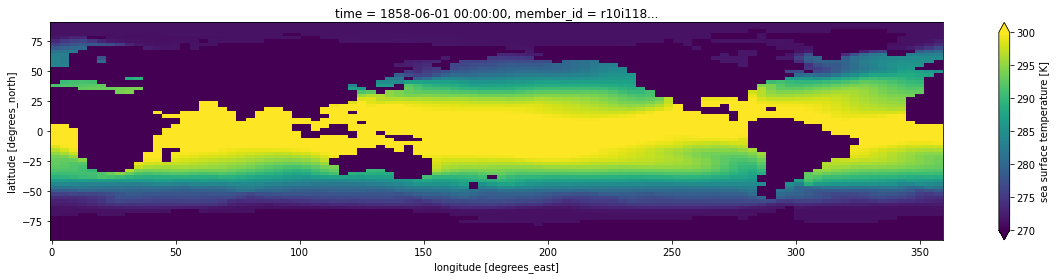

In [150]:
#Plot 1st member to check that it looks right
plt.figure(figsize=(20,4))
sst1.isel(time=100).plot(vmax=300,vmin=270)


(0.036826478293857906, 0.10138087898937943)

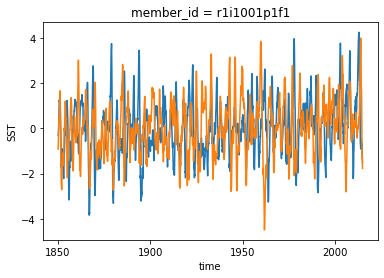

In [151]:
#Look at another ensemble member to see how correlated they are
#If they aren't correlated, we can use separate members for validation

ds2 = xr.open_dataset('LENS2/ENSO_SST/ENSO_Project_SST_r1i1001p1f1.nc')
#ds2 = ds2.sel(lat=slice(-15,15),lon=slice(120,180+(180-80)))
sst2 = ds2.SST

#calculate nino34 index and compare them
sst1_clim = sst1.groupby("time.month").mean('time')  
sst1_anom = sst1.groupby("time.month") - sst1_clim
nino34_1 = sst1_anom.sel(lat=slice(-5,5),lon=slice(190,240)).mean(dim=['lat','lon'])

sst2_clim = sst2.groupby("time.month").mean('time')  
sst2_anom = sst2.groupby("time.month") - sst2_clim
nino34_2 = sst2_anom.sel(lat=slice(-5,5),lon=slice(190,240)).mean(dim=['lat','lon'])

plt.figure()
nino34_1.plot()
nino34_2.plot()

from scipy.stats import pearsonr
corr, sig = pearsonr(nino34_1,nino34_2)
corr, sig 
#correlation is very low and not significant so we can use othermembers as validation. 


In [152]:
#set up X and Y for populating
#n_samples,n_lats,n_lons,n_channels (n_months)
X = np.zeros((300*10,n_lats,n_lons,12))
Y = np.zeros((300*10,12))

#randomly sample 300 times from each of the 10 ensembles
ens_names = ['1i1001','2i1021','3i1041','4i1061','5i1081','6i1101','7i1121','8i1141','9i1161','10i1181']
for ens in range(10):
    
    #get ens SST data
    print('Ensemble',ens)
    ens_name = ens_names[ens]
    ds = xr.open_dataset('LENS2/ENSO_SST/ENSO_Project_SST_r'+ens_name+'p1f1.nc')
    
    #select large tropical Pacific region
    #ds = ds.sel(lat=slice(-15,15),lon=slice(120,180+(180-80)))
    sst = ds.SST
    n_months = sst.shape[0]
    
    #calculate anomaly by removing climatology
    sst_clim = sst.groupby("time.month").mean('time')  
    sst_anom = sst.groupby("time.month") - sst_clim #shape 1980,10,43 (1980 = 165*12)
    #print(sst_anom.shape)
    
    #randomly generate a num k between 1 and 165*12, 300 times
    for j in range(300):
        idx = ens*300 + j #for 0th ens populate indices 0-299, for 1st populate 300-599, ...
        
        #select a starting month from the available ensemble timesteps 
        k = np.random.randint(1,n_months-24)
        
        #select random 12-month chunk using number j and make x_j
        rand_sst_xj = sst_anom[k:k+12,:,:] #shape (12,n_lats,n_lons)
        rand_sst_xj = np.array(rand_sst_xj)
        
        #transpose so time is last; shape (nlat,nlon,12); reshape corrupts data
        rand_sst_rs = np.transpose(rand_sst_xj, (1,2,0))
        
        #populate X matrix
        X[idx,:,:,:] = rand_sst_rs
        
        #get next 12 months and calculate nino34 index to make y_i
        rand_sst_yj = sst_anom[k+12:k+24,:,:] #shape (12,10,43)
        nino34_j = rand_sst_yj.sel(lat=slice(-5,5),lon=slice(190,240)).mean(dim=['lat','lon'])
        
        #populate Y matrix
        Y[idx,:] = nino34_j.values
    

Ensemble 0
Ensemble 1
Ensemble 2
Ensemble 3
Ensemble 4
Ensemble 5
Ensemble 6
Ensemble 7
Ensemble 8
Ensemble 9


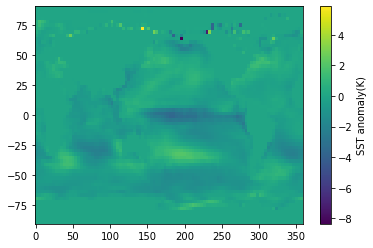

In [153]:
#plot the last random sample to make sure it's not corrupted after reshaping

rand_sst_rs.shape
test_sst = rand_sst_rs[:,:,0]
#test_sst = rand_sst_xj[0,:,:] #for checking before reshaping
lon,lat = ds1.lon,ds1.lat

plt.figure()
plt.pcolormesh(lon,lat,test_sst)
plt.colorbar(label='SST anomaly(K)')

In [154]:
#Split into training and validation (1st 90% or 9 members )

X_train = X[0:300*9,:,:]
X_valid = X[300*9:,:,:]

Y_train = Y[0:300*9,:]
Y_valid = Y[300*9:,:]

X_train.shape,X_valid.shape

((2700, 64, 96, 12), (300, 64, 96, 12))

In [155]:
#save numpy arrays (caution-- saves over existing files)
np.save('X_train.npy',X_train)
np.save('X_valid.npy',X_valid)
np.save('Y_train.npy',Y_train)
np.save('Y_valid.npy',Y_valid)